In [1]:
# For colab users
!pip install medmnist
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=89e04e14124e974ce926abd3dcfbcf7153d48661b6c6fc28942ddfdb7d5a10e5
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.3 MB/s eta 0:00:00


In [2]:

import copy

import medmnist
import torchvision.transforms

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import seaborn as sns

import medmnist
from medmnist import INFO

In [3]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()

            # TODO: Convert to binary classification
            if convert_to_binary:
                targets = torch.where(torch.sum(targets, dim=1) == 0, 0, 1)

            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            loss.backward()
            optimizer.step()
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
    return model

In [4]:
def test(model, data_loader, device, convert_to_binary):
    model.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()
            # TODO: Convert to binary classification
            if convert_to_binary:
                targets = torch.where(torch.sum(targets, dim=1) == 0, 0, 1)


            outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_preds = torch.max(y_score, dim=1)[1]

        # TODO: Accuracy
        total_correct_pred= torch.sum(y_true==y_preds)
        acc = total_correct_pred/len(y_preds)

        print('acc:%.3f' % (acc))

# Chest

In [5]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
#n_classes_chest = len(info_chest['label'])
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'])

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download)
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

100%|██████████| 82802576/82802576 [00:03<00:00, 22084385.30it/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [7]:
# define a simple CNN model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Linear(128*4, num_classes)
        )

        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)

        ### extract embeddings
        if self.extract_embeddings:
            return x

        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch: 1	Loss: 0.8028


100%|██████████| 5/5 [00:00<00:00, 69.39it/s]


Epoch: 2	Loss: 0.6612


100%|██████████| 5/5 [00:00<00:00, 70.75it/s]


Epoch: 3	Loss: 0.5704


100%|██████████| 5/5 [00:00<00:00, 79.66it/s]


Epoch: 4	Loss: 0.4964


100%|██████████| 5/5 [00:00<00:00, 78.27it/s]


Epoch: 5	Loss: 0.4421


100%|██████████| 5/5 [00:00<00:00, 80.09it/s]


Epoch: 6	Loss: 0.3881


100%|██████████| 5/5 [00:00<00:00, 80.28it/s]


Epoch: 7	Loss: 0.3487


100%|██████████| 5/5 [00:00<00:00, 74.34it/s]


Epoch: 8	Loss: 0.3194


100%|██████████| 5/5 [00:00<00:00, 83.28it/s]


Epoch: 9	Loss: 0.2817


100%|██████████| 5/5 [00:00<00:00, 84.28it/s]


Epoch: 10	Loss: 0.2543


100%|██████████| 5/5 [00:00<00:00, 73.68it/s]


Epoch: 11	Loss: 0.2307


100%|██████████| 5/5 [00:00<00:00, 73.85it/s]


Epoch: 12	Loss: 0.2060


100%|██████████| 5/5 [00:00<00:00, 81.09it/s]


Epoch: 13	Loss: 0.1809


100%|██████████| 5/5 [00:00<00:00, 72.45it/s]


Epoch: 14	Loss: 0.1654


100%|██████████| 5/5 [00:00<00:00, 70.74it/s]


Epoch: 15	Loss: 0.1476


100%|██████████| 5/5 [00:00<00:00, 62.10it/s]


Epoch: 16	Loss: 0.1296


100%|██████████| 5/5 [00:00<00:00, 77.00it/s]


Epoch: 17	Loss: 0.1214


100%|██████████| 5/5 [00:00<00:00, 76.90it/s]


Epoch: 18	Loss: 0.1095


100%|██████████| 5/5 [00:00<00:00, 80.55it/s]


Epoch: 19	Loss: 0.0940


100%|██████████| 5/5 [00:00<00:00, 73.70it/s]

Epoch: 20	Loss: 0.0883


In [8]:
# examine the data distribution of the binary classification task. Is accuracy a good metric?
test(model_chest, test_loader_chest, device, convert_to_binary=True)

acc:0.582


[Text(0, 0, 'Healthy'), Text(1, 0, 'Diseased')]

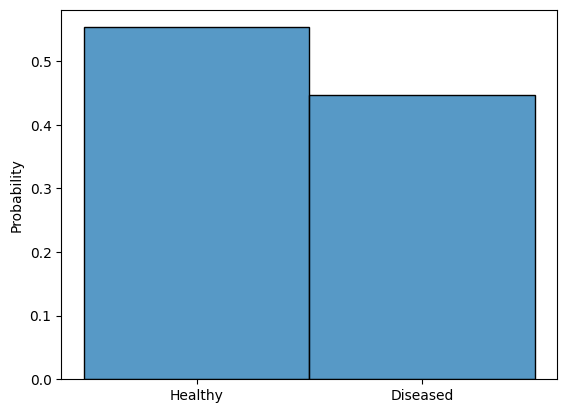

In [9]:
# show probabilities for binary labels in data distribution
binary_labels = np.where(np.sum(train_dataset_chest.labels, axis=1)==0, 0, 1)
ax = sns.histplot(binary_labels, stat='probability', bins=2, discrete=True)
ax.set_xticks((0, 1))
ax.set_xticklabels(('Healthy', 'Diseased'))

In [10]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_chest, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_chest, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
acc:0.997
test
acc:0.582


## Latent Space

Embeddings shape: (22433, 512)
PCA output shape: (22433, 2)


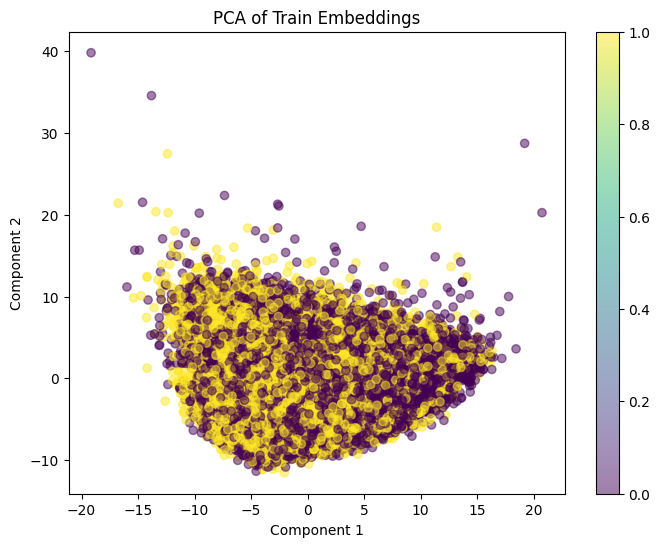

t-SNE output shape: (22433, 2)


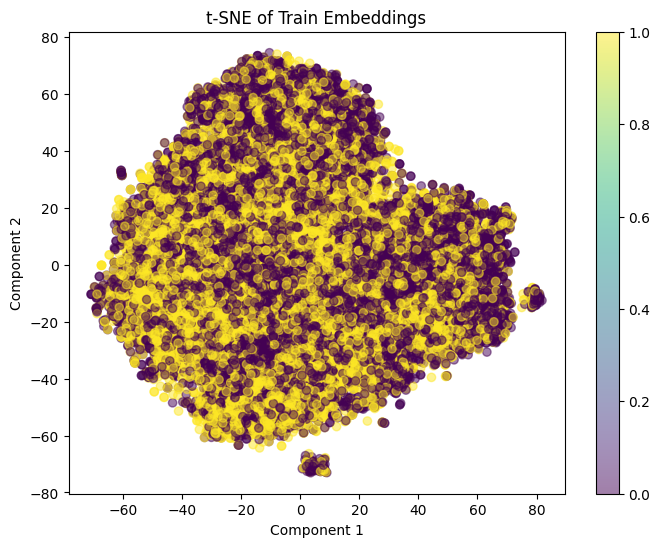

In [11]:
# EXAMINE LATENT SPACE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False

            embeddings.append(output)
            labels.append(target)

    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_chest) ###

# TODO: convert labels to binary
test_labels = torch.where(torch.sum(test_labels, axis=1)==0, 0, 1)

import numpy as np
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()
print('Embeddings shape:', test_embeddings_flat.shape)

# TODO: Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) ### create model
pca_result = pca.fit_transform(test_embeddings_flat) ### apply trafo
print('PCA output shape:', pca_result.shape)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# TODO: Apply t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init=pca_result, perplexity=50) ### create model
tsne_result = tsne.fit_transform(test_embeddings_flat) ### apply trafo
print('t-SNE output shape:', tsne_result.shape)

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')

## Autoencoder

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Define an autoencoder model that is compatible with the previous model. Use dropout with probability p
class Autoencoder(nn.Module):
    def __init__(self, p):
        super(Autoencoder, self).__init__()

        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        )

        self.decode = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=3, padding=1)
        )

    def forward(self, x):
        x = self.encode(x) # create the latent image
        x = self.decode(x) # from the latent image create output
        return x

# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.2).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0015, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_ae.train()
    for x in train_loader_chest_full:
        inputs, _ = x
        inputs = inputs.to(device)

        # Forward pass
        outputs = model_ae(inputs)
        # print(outputs.shape, inputs.shape)
        loss = criterion_ae(outputs, inputs)

        psnr_value = psnr_metric(outputs, inputs)
        ssim_value = ssim_metric(outputs, inputs)

        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

    # Print the metrics for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)
        outputs = model_ae(inputs)

        loss = criterion_ae(outputs, inputs)
        psnr_value_test = psnr_metric(outputs, inputs)
        ssim_value_test = ssim_metric(outputs, inputs)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')


Epoch [1/10], Loss: 0.0426, PSNR: 19.4533, SSIM: 0.6338
Epoch [2/10], Loss: 0.0353, PSNR: 20.2366, SSIM: 0.6585
Epoch [3/10], Loss: 0.0296, PSNR: 21.0718, SSIM: 0.6956
Epoch [4/10], Loss: 0.0300, PSNR: 20.9793, SSIM: 0.6978
Epoch [5/10], Loss: 0.0284, PSNR: 21.2065, SSIM: 0.6888
Epoch [6/10], Loss: 0.0275, PSNR: 21.2875, SSIM: 0.6952
Epoch [7/10], Loss: 0.0267, PSNR: 21.4012, SSIM: 0.7195
Epoch [8/10], Loss: 0.0256, PSNR: 21.7668, SSIM: 0.7130
Epoch [9/10], Loss: 0.0254, PSNR: 21.6921, SSIM: 0.7160
Epoch [10/10], Loss: 0.0273, PSNR: 21.4218, SSIM: 0.7098
Average Test Loss: 0.0002, Average PSNR: 24.3681, Average SSIM: 0.8360


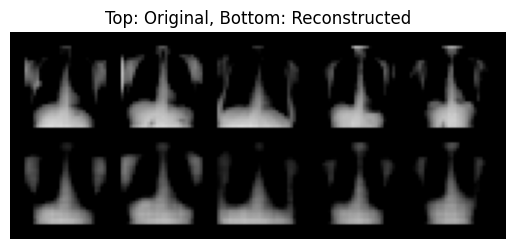

In [13]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# TODO: Function to plot input and output images
def plot_images(model, test_loader, device, num_images=5):
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        batch_images, _ = next(iter(test_loader))
        batch_images = batch_images.to(device)

        batch_reconstructed = model(batch_images)

        for i in range(num_images):
            reconstructed = batch_reconstructed[i]
            original = batch_images[i]

            original_images.append(original)
            reconstructed_images.append(reconstructed)

    images = original_images + reconstructed_images
    grid = make_grid(images, nrow=5, padding=5)
    grid = grid.permute(1, 2, 0)
    plt.title("Top: Original, Bottom: Reconstructed")
    plt.imshow(grid.cpu())
    plt.axis("off")
    plt.show()

# Use the function to plot images
plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [14]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# TODO: Transfer the weights into the new model
# Get encoder weights from model_ae, switch initial weights of mode_transfer with encoder weights
model_transfer.layer1[0].load_state_dict(model_ae.encode[0].state_dict())
model_transfer.layer2[0].load_state_dict(model_ae.encode[3].state_dict())
model_transfer.layer3[0].load_state_dict(model_ae.encode[6].state_dict())
model_transfer.layer4[0].load_state_dict(model_ae.encode[9].state_dict())

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 5/5 [00:00<00:00, 79.96it/s]


Epoch: 1	Loss: 0.7022


100%|██████████| 5/5 [00:00<00:00, 83.97it/s]


Epoch: 2	Loss: 0.6590


100%|██████████| 5/5 [00:00<00:00, 84.31it/s]


Epoch: 3	Loss: 0.6230


100%|██████████| 5/5 [00:00<00:00, 86.21it/s]


Epoch: 4	Loss: 0.6004


100%|██████████| 5/5 [00:00<00:00, 82.39it/s]


Epoch: 5	Loss: 0.5835


100%|██████████| 5/5 [00:00<00:00, 75.57it/s]


Epoch: 6	Loss: 0.5582


100%|██████████| 5/5 [00:00<00:00, 66.95it/s]


Epoch: 7	Loss: 0.5566


100%|██████████| 5/5 [00:00<00:00, 76.37it/s]


Epoch: 8	Loss: 0.5426


100%|██████████| 5/5 [00:00<00:00, 79.50it/s]


Epoch: 9	Loss: 0.5213


100%|██████████| 5/5 [00:00<00:00, 78.85it/s]


Epoch: 10	Loss: 0.5159


100%|██████████| 5/5 [00:00<00:00, 77.13it/s]


Epoch: 11	Loss: 0.5141


100%|██████████| 5/5 [00:00<00:00, 78.08it/s]


Epoch: 12	Loss: 0.5020


100%|██████████| 5/5 [00:00<00:00, 68.24it/s]


Epoch: 13	Loss: 0.5020


100%|██████████| 5/5 [00:00<00:00, 73.22it/s]


Epoch: 14	Loss: 0.4829


100%|██████████| 5/5 [00:00<00:00, 81.49it/s]


Epoch: 15	Loss: 0.4774


100%|██████████| 5/5 [00:00<00:00, 83.51it/s]


Epoch: 16	Loss: 0.4787


100%|██████████| 5/5 [00:00<00:00, 72.28it/s]


Epoch: 17	Loss: 0.4634


100%|██████████| 5/5 [00:00<00:00, 83.56it/s]


Epoch: 18	Loss: 0.4698


100%|██████████| 5/5 [00:00<00:00, 72.60it/s]


Epoch: 19	Loss: 0.4596


100%|██████████| 5/5 [00:00<00:00, 81.16it/s]

Epoch: 20	Loss: 0.4489


In [15]:
print('==> Evaluating ...')
print('train')
test(model_transfer, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_transfer, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
acc:0.810
test
acc:0.587


# Pneumonia

In [16]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

100%|██████████| 4170669/4170669 [00:00<00:00, 4323336.45it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [17]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [18]:
# train

model_pneumonia = train(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:01<00:00, 52.99it/s]


Epoch: 1	Loss: 0.2069


100%|██████████| 74/74 [00:01<00:00, 55.71it/s]


Epoch: 2	Loss: 0.0978


100%|██████████| 74/74 [00:01<00:00, 60.06it/s]


Epoch: 3	Loss: 0.0745


100%|██████████| 74/74 [00:00<00:00, 76.55it/s]


Epoch: 4	Loss: 0.0574


100%|██████████| 74/74 [00:00<00:00, 75.77it/s]


Epoch: 5	Loss: 0.0462


100%|██████████| 74/74 [00:00<00:00, 75.01it/s]


Epoch: 6	Loss: 0.0349


100%|██████████| 74/74 [00:00<00:00, 75.74it/s]


Epoch: 7	Loss: 0.0273


100%|██████████| 74/74 [00:00<00:00, 75.91it/s]


Epoch: 8	Loss: 0.0237


100%|██████████| 74/74 [00:00<00:00, 76.71it/s]


Epoch: 9	Loss: 0.0179


100%|██████████| 74/74 [00:00<00:00, 76.15it/s]

Epoch: 10	Loss: 0.0147


In [19]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
acc:0.999
test
acc:0.821


## Transfer learning

In [20]:
# For transfer learning lets go back to the full dataset

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 307/307 [00:14<00:00, 20.93it/s]


Epoch: 1	Loss: 0.6507


100%|██████████| 307/307 [00:14<00:00, 20.64it/s]


Epoch: 2	Loss: 0.6309


100%|██████████| 307/307 [00:16<00:00, 19.02it/s]


Epoch: 3	Loss: 0.6231


100%|██████████| 307/307 [00:14<00:00, 20.53it/s]


Epoch: 4	Loss: 0.6176


100%|██████████| 307/307 [00:14<00:00, 20.78it/s]


Epoch: 5	Loss: 0.6123


100%|██████████| 307/307 [00:14<00:00, 20.89it/s]


Epoch: 6	Loss: 0.6077


100%|██████████| 307/307 [00:14<00:00, 21.30it/s]


Epoch: 7	Loss: 0.6030


100%|██████████| 307/307 [00:14<00:00, 20.97it/s]


Epoch: 8	Loss: 0.5978


100%|██████████| 307/307 [00:14<00:00, 21.40it/s]


Epoch: 9	Loss: 0.5930


100%|██████████| 307/307 [00:14<00:00, 20.93it/s]


Epoch: 10	Loss: 0.5875


100%|██████████| 307/307 [00:14<00:00, 21.31it/s]


Epoch: 11	Loss: 0.5824


100%|██████████| 307/307 [00:14<00:00, 21.19it/s]


Epoch: 12	Loss: 0.5776


100%|██████████| 307/307 [00:14<00:00, 21.45it/s]


Epoch: 13	Loss: 0.5719


100%|██████████| 307/307 [00:14<00:00, 21.07it/s]


Epoch: 14	Loss: 0.5652


100%|██████████| 307/307 [00:14<00:00, 20.90it/s]


Epoch: 15	Loss: 0.5601


100%|██████████| 307/307 [00:20<00:00, 15.35it/s]


Epoch: 16	Loss: 0.5531


100%|██████████| 307/307 [00:24<00:00, 12.70it/s]


Epoch: 17	Loss: 0.5482


100%|██████████| 307/307 [00:14<00:00, 21.06it/s]


Epoch: 18	Loss: 0.5399


100%|██████████| 307/307 [00:22<00:00, 13.61it/s]


Epoch: 19	Loss: 0.5329


100%|██████████| 307/307 [00:24<00:00, 12.57it/s]

Epoch: 20	Loss: 0.5278


### Transfer learning - Frozen

In [21]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model
model_pneumonia_transfer_frozen.layer1[0].load_state_dict(model_ae.encode[0].state_dict())
model_pneumonia_transfer_frozen.layer2[0].load_state_dict(model_ae.encode[3].state_dict())
model_pneumonia_transfer_frozen.layer3[0].load_state_dict(model_ae.encode[6].state_dict())
model_pneumonia_transfer_frozen.layer4[0].load_state_dict(model_ae.encode[9].state_dict())
# TODO: Freeze all layers except the FC
for name, layer in model_pneumonia_transfer_frozen.named_children():
  if name != 'fc':
    layer.requires_grad_ = False
  print("Layer:",  name, "Frozen:", not bool(layer.requires_grad_))

# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

Layer: layer1 Frozen: True
Layer: layer2 Frozen: True
Layer: layer3 Frozen: True
Layer: layer4 Frozen: True
Layer: fc Frozen: False


In [22]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:01<00:00, 68.65it/s]


Epoch: 1	Loss: 0.2487


100%|██████████| 74/74 [00:01<00:00, 73.97it/s]


Epoch: 2	Loss: 0.1389


100%|██████████| 74/74 [00:01<00:00, 38.04it/s]


Epoch: 3	Loss: 0.1241


100%|██████████| 74/74 [00:03<00:00, 24.61it/s]


Epoch: 4	Loss: 0.1102


100%|██████████| 74/74 [00:01<00:00, 53.11it/s]


Epoch: 5	Loss: 0.1048


100%|██████████| 74/74 [00:01<00:00, 44.83it/s]


Epoch: 6	Loss: 0.0982


100%|██████████| 74/74 [00:01<00:00, 43.80it/s]


Epoch: 7	Loss: 0.0924


100%|██████████| 74/74 [00:01<00:00, 66.55it/s]


Epoch: 8	Loss: 0.0886


100%|██████████| 74/74 [00:01<00:00, 73.37it/s]


Epoch: 9	Loss: 0.0834


100%|██████████| 74/74 [00:01<00:00, 73.67it/s]

Epoch: 10	Loss: 0.0796


In [23]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
acc:0.976
test
acc:0.864


Embeddings shape: (624, 512)
PCA output shape: (624, 2)
t-SNE output shape: (624, 2)


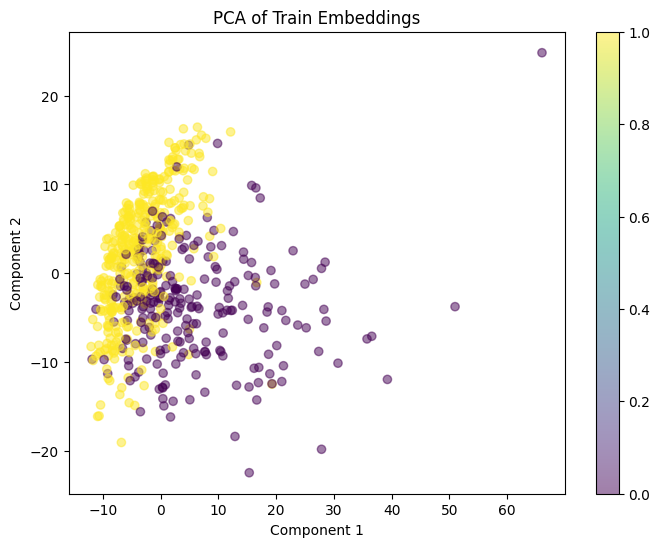

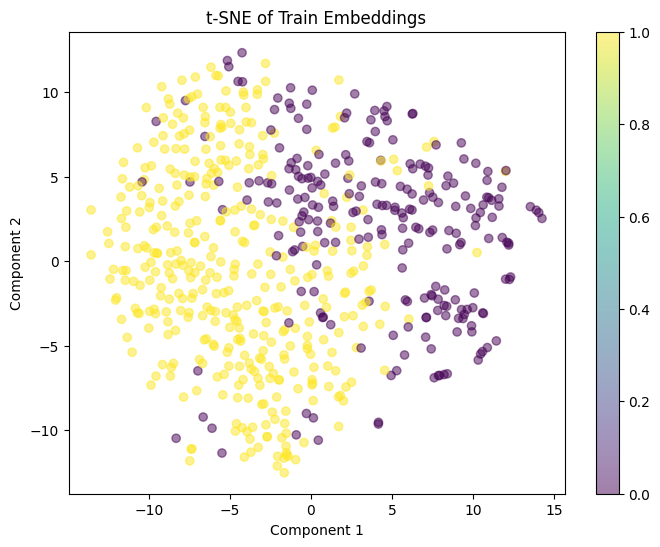

In [24]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# TODO: convert labels to binary
test_labels = torch.where(torch.sum(test_labels, axis=1)==0, 0, 1)

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()
print('Embeddings shape:', test_embeddings_flat.shape)
# TODO: Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) ### create model
pca_result = pca.fit_transform(test_embeddings_flat) ### apply trafo
print('PCA output shape:', pca_result.shape)

# TODO: Apply t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init=pca_result, perplexity=70, n_iter=5000) ### create model
tsne_result = tsne.fit_transform(test_embeddings_flat) ### apply trafo
print('t-SNE output shape:', tsne_result.shape)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [25]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model

# Same as above, because in task the wording is: "NOW DO THE SAME but leave the model trainable.""
model_pneumonia_transfer_trainable.layer1[0].load_state_dict(model_ae.encode[0].state_dict())
model_pneumonia_transfer_trainable.layer2[0].load_state_dict(model_ae.encode[3].state_dict())
model_pneumonia_transfer_trainable.layer3[0].load_state_dict(model_ae.encode[6].state_dict())
model_pneumonia_transfer_trainable.layer4[0].load_state_dict(model_ae.encode[9].state_dict())

#not freezing anything ""Now do the same but LEAVE THE MODEL TRAINABLE."""

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [26]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:01<00:00, 72.43it/s]


Epoch: 1	Loss: 0.2391


100%|██████████| 74/74 [00:01<00:00, 72.62it/s]


Epoch: 2	Loss: 0.1474


100%|██████████| 74/74 [00:01<00:00, 73.55it/s]


Epoch: 3	Loss: 0.1305


100%|██████████| 74/74 [00:00<00:00, 74.74it/s]


Epoch: 4	Loss: 0.1167


100%|██████████| 74/74 [00:01<00:00, 59.76it/s]


Epoch: 5	Loss: 0.1084


100%|██████████| 74/74 [00:01<00:00, 54.03it/s]


Epoch: 6	Loss: 0.0996


100%|██████████| 74/74 [00:01<00:00, 51.82it/s]


Epoch: 7	Loss: 0.0952


100%|██████████| 74/74 [00:01<00:00, 72.35it/s]


Epoch: 8	Loss: 0.0891


100%|██████████| 74/74 [00:01<00:00, 72.43it/s]


Epoch: 9	Loss: 0.0869


100%|██████████| 74/74 [00:00<00:00, 75.43it/s]

Epoch: 10	Loss: 0.0818


In [27]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
acc:0.974
test
acc:0.873


PCA output shape: (624, 2)
t-SNE output shape: (624, 2)


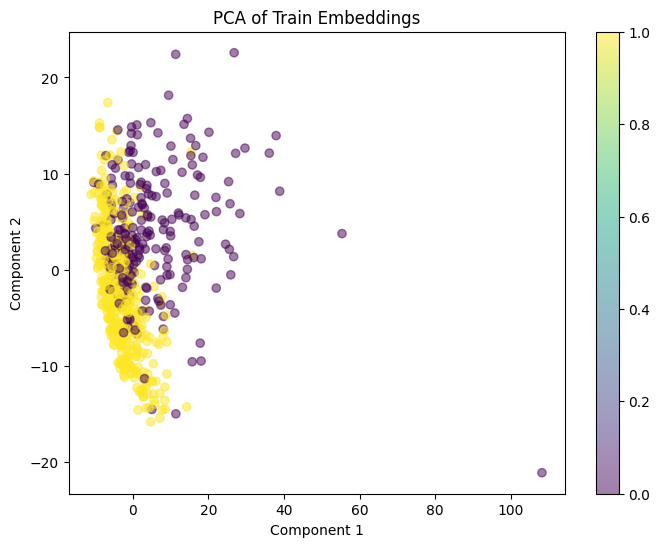

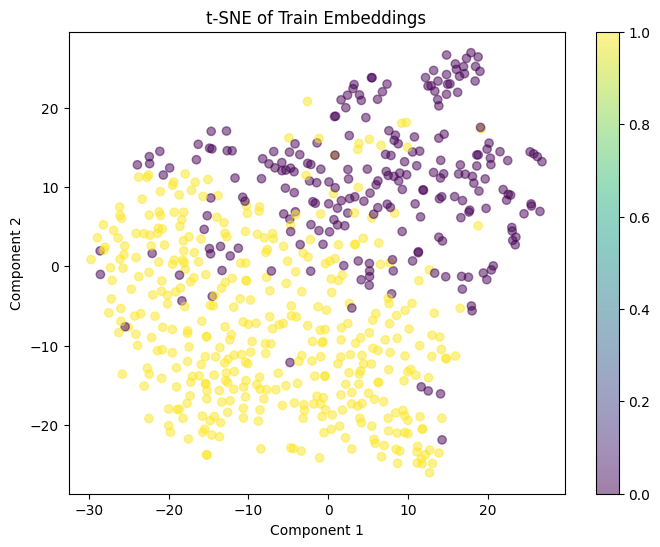

In [28]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

from sklearn.decomposition import PCA
pca = PCA(n_components=2) ### create model
pca_result = pca.fit_transform(test_embeddings_flat) ### apply trafo
print('PCA output shape:', pca_result.shape)

# TODO: Apply t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init=pca_result) ### create model
tsne_result = tsne.fit_transform(test_embeddings_flat) ### apply trafo
print('t-SNE output shape:', tsne_result.shape)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')

### BONUS: Transfer learning